# Find cell type specific bindnig

In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from plot_params import *
out_stem = 'K562_rep6'
basedir = Path('/tscc/nfs/home/hsher/scratch/ABC_2rep/')
df = pd.read_csv(basedir / f'DMM/{out_stem}.megaoutputs.tsv', sep = '\t', index_col = 0)
df['name'] = df.index

out_stem1 = 'K562_rep4'
df1 = pd.read_csv(basedir / f'DMM/{out_stem1}.megaoutputs.tsv', sep = '\t', index_col = 0)
df1['name'] = df1.index

out_stem2 = 'HEK293_rep1'
df2 = pd.read_csv(basedir / f'DMM/{out_stem2}.megaoutputs.tsv', sep = '\t', index_col = 0)
df2['name'] = df2.index

out_stem3 = 'HEK293_rep2'
df3 = pd.read_csv(basedir / f'DMM/{out_stem3}.megaoutputs.tsv', sep = '\t', index_col = 0)
df3['name'] = df3.index


In [2]:
seq = pd.read_csv('/tscc/nfs/home/hsher/ps-yeolab5/ABC_DL/HEK293_rep1.DDX3.tsv', sep = '\t', 
                 names = ['chrom', 'name', 'seq', 'struct', 'label', '-'])


In [3]:

window_df = pd.read_csv('/tscc/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz', sep = '\t')

pum_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_pum2.homer.motif', sep = '\t')
pum_motif = pum_motif.loc[pum_motif['Motif Name']=='1-TGTATATA']
pum_motif['windowstrand']=pum_motif['PositionID'].map(window_df.set_index('name')['strand'])
pum_motif.dropna(inplace = True)
pum_motif = pum_motif.loc[pum_motif['Strand']==pum_motif['windowstrand']]

rbfox2_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_rbfox2.homer.motif', sep = '\t')
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Motif Name']=='1-TGCATG']
rbfox2_motif['windowstrand']=rbfox2_motif['PositionID'].map(window_df.set_index('name')['strand'])
rbfox2_motif.dropna(inplace = True)
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Strand']==rbfox2_motif['windowstrand']]


In [4]:
mega_df = df.merge(df2.loc[:, df2.columns.str.contains('logLR:')], left_index = True, right_index = True
                  ).merge(df1.loc[:, df1.columns.str.contains('logLR:')], left_index = True, right_index = True
                ).merge(df3.loc[:, df3.columns.str.contains('logLR:')], left_index = True, right_index = True
                       )

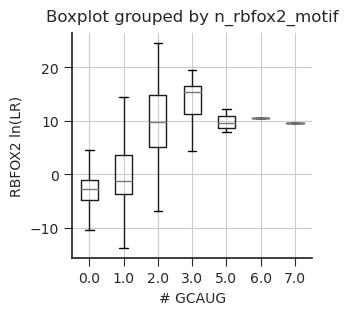

In [6]:
mega_df['is_rbfox2_motif']=mega_df.index.isin(rbfox2_motif['PositionID'])
mega_df['n_rbfox2_motif']=rbfox2_motif.groupby(by = ['PositionID']).count()['Offset']
mega_df['n_rbfox2_motif'] = mega_df['n_rbfox2_motif'].fillna(0)
mega_df.boxplot(by = ['n_rbfox2_motif'], column = [f'logLR:{out_stem}.RBFOX2'],
               showfliers = False, figsize = (3,3))
plt.ylabel('RBFOX2 ln(LR)')
plt.xlabel('Number GCAUG')
plt.title('')
sns.despine()
plt.savefig(figdir / 'logLR_nGCAUG.pdf')

In [7]:
secondary_motif = ['GCACG', 'GCUUG', 'GAAUG', 'GUUUG', 'GUAUG', 'GUGUG', 'GCCUG', 'GCAUG']
is_secondary = pd.concat([seq.set_index('name')['seq'].str.count(m.replace('U', 'T'))
                               for m in secondary_motif
                               ], axis = 1)
is_secondary.columns = [m for m in secondary_motif]
mega_df = mega_df.merge(is_secondary, left_index = True, right_index = True
                 )

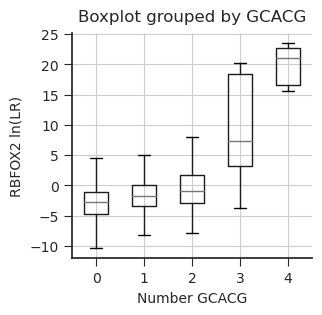

In [22]:

mega_df.boxplot(by = ['GCACG'], column = [f'logLR:{out_stem}.RBFOX2'],
               showfliers = False, figsize = (3,3))
plt.ylabel('RBFOX2 ln(LR)')
plt.xlabel('Number GCACG')
plt.title('')
sns.despine()
plt.savefig(figdir / 'logLR_nGCACG.pdf')

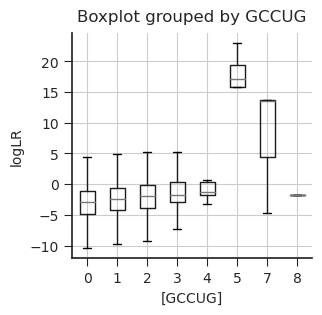

In [11]:
mega_df.boxplot(by = ['GCCUG'], column = [f'logLR:{out_stem}.RBFOX2'],
               showfliers = False, figsize = (3,3))
plt.ylabel('logLR')
plt.title('')
sns.despine()
plt.savefig(figdir / 'logLR_nGCCUG.pdf')

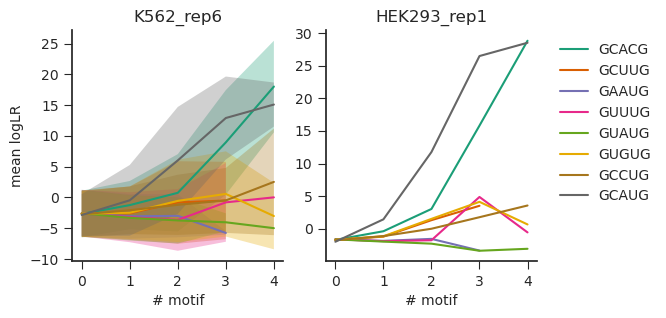

In [12]:
f, ax = plt.subplots(1,2, figsize = (6,3))

for m in secondary_motif:
    mean1 = mega_df.groupby(by = [m])[f'logLR:{out_stem}.RBFOX2'].mean()[:5]
    std1 = mega_df.groupby(by = [m])[f'logLR:{out_stem}.RBFOX2'].std()[:5]
    mean1.plot(
    label = m,
    ax = ax[0]
    )
    ax[0].fill_between(mean1.index, mean1-std1, mean1+std1, alpha = 0.3)
    
    mega_df.groupby(by = [m])[f'logLR:{out_stem2}.RBFOX2'].mean()[:5].plot(
    label = m,
    ax = ax[1]
    )

ax[0].set_ylabel('mean logLR')
ax[0].set_title(out_stem)
ax[1].set_title(out_stem2)
ax[1].set_xlabel('# motif')
ax[0].set_xlabel('# motif')
ax[1].legend(bbox_to_anchor = (1.6,1))
sns.despine()
plt.savefig(figdir/'logLR_rbfox2motif.pdf')

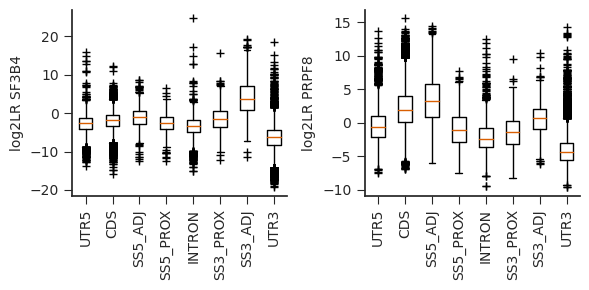

In [13]:
f, ax = plt.subplots(1,2, figsize = (6,3), sharex = True)

features = ['UTR5','CDS','SS5_ADJ','SS5_PROX','INTRON', 'SS3_PROX','SS3_ADJ','UTR3']

values = []
values2 = []
for i, f in enumerate(features):
    values.append(mega_df.loc[mega_df['feature_type_top'].isin([f]), f'logLR:{out_stem}.SF3B4'])
    values2.append(mega_df.loc[mega_df['feature_type_top'].isin([f]), f'logLR:{out_stem}.PRPF8'])

    
ax[0].boxplot(values,sym='+')
ax[1].boxplot(values2,sym='+')
ax[0].set_xticks(range(1,len(features)+1))
ax[0].set_xticklabels(features, rotation= 90)
ax[1].set_xticklabels(features,rotation = 90)
ax[0].set_ylabel('log2LR SF3B4')
ax[1].set_ylabel('log2LR PRPF8')
sns.despine()
plt.tight_layout()
plt.savefig(figdir/'logLR_regions_splicefactor.pdf')

In [14]:
n_lin28_ggag = seq.set_index('name')['seq'].str.count('GGAG')
n_lin28_ugau = seq.set_index('name')['seq'].str.count('TGAT')
mega_df['n_GGAG']=n_lin28_ggag
mega_df['n_UGAU']=n_lin28_ugau


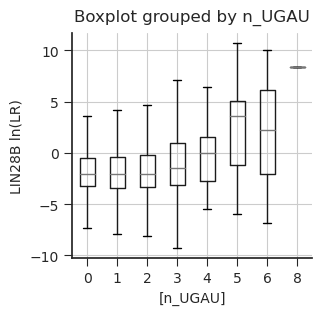

In [16]:
mega_df.boxplot(by = ['n_UGAU'], column = [f'logLR:{out_stem}.LIN28B'],
               showfliers = False, figsize = (3,3))
plt.ylabel('LIN28B ln(LR)')
plt.title('')
sns.despine()
plt.savefig(figdir / 'logLR_nUGAU')

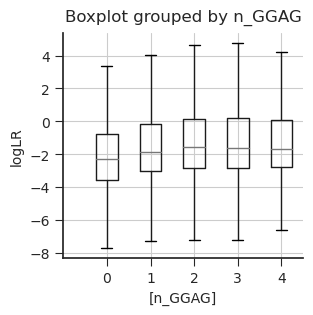

In [17]:
mega_df.boxplot(by = ['n_GGAG'], column = [f'logLR:{out_stem}.LIN28B'],
               showfliers = False, figsize = (3,3))
plt.ylabel('logLR')
plt.xlim(0,5.5)
plt.title('')
sns.despine()
plt.savefig(figdir / 'logLR_nGGAG')

In [18]:
ccle_rpkm = pd.read_csv('/tscc/projects/ps-yeolab5/hsher/ccle_datasets/CCLE_RNAseq_genes_rpkm_20180929.gct.gz',
                   comment = '#',sep = '\t', skiprows = 2).drop_duplicates(subset = 'Description')

In [19]:
mega_df['K562_RPKM']=mega_df['gene_name'].map(ccle_rpkm.set_index('Description')['K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE'])

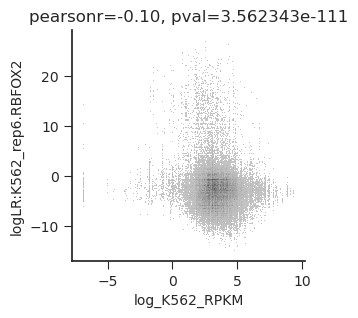

In [20]:
import numpy as np
from scipy.stats import pearsonr
mega_df['log_K562_RPKM'] = np.log(mega_df['K562_RPKM']+0.001)
f, ax = plt.subplots(figsize = (3,3))
sns.histplot(data = mega_df, x = 'log_K562_RPKM', y = f'logLR:{out_stem}.RBFOX2', ax = ax, color = 'grey')
r,p = pearsonr(mega_df.loc[~mega_df['log_K562_RPKM'].isnull(), 'log_K562_RPKM'], 
         mega_df.loc[~mega_df['log_K562_RPKM'].isnull(), f'logLR:{out_stem}.RBFOX2'])
plt.title(f'pearsonr={r:.2f}, pval={p:2e}')
sns.despine()
plt.savefig(figdir/'lnLR_RPKM.pdf')

In [22]:
rpkm = pd.read_csv('ENCFF718ZTE.tsv', sep = '\t')

In [23]:
rpkm.head()

,gene_id,transcript_id(s),length,effective_length,expected_count,TPM,FPKM,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,TPM_ci_lower_bound,TPM_ci_upper_bound,TPM_coefficient_of_quartile_variation,FPKM_ci_lower_bound,FPKM_ci_upper_bound,FPKM_coefficient_of_quartile_variation
0,10904,10904,93.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12954,12954,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12956,12956,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12958,12958,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12960,12960,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

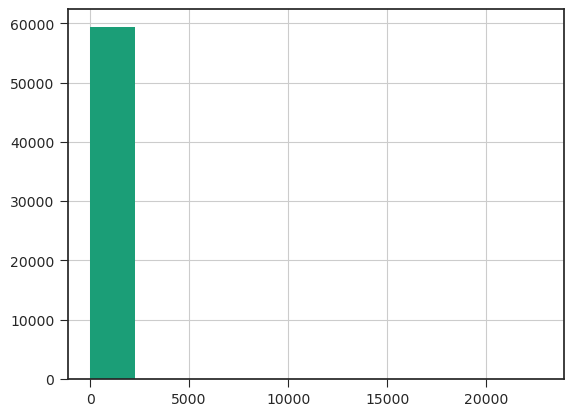

In [24]:
rpkm['TPM'].hist()

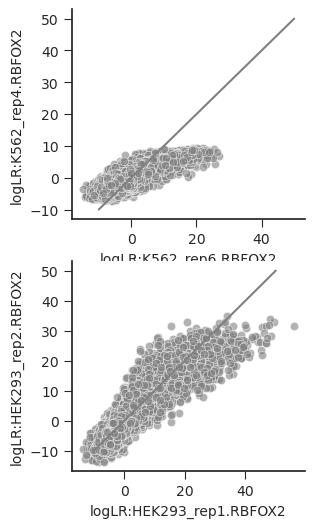

In [25]:
f, ax = plt.subplots(2,1, figsize = (3,6))
sns.scatterplot(data=mega_df ,x=f'logLR:{out_stem}.RBFOX2', y=f'logLR:{out_stem1}.RBFOX2', alpha = 0.6, ax =ax[0],
               color = 'grey')
ax[0].plot([-10,50], [-10,50], color = 'grey')

sns.scatterplot(data=mega_df ,x=f'logLR:{out_stem2}.RBFOX2', y=f'logLR:{out_stem3}.RBFOX2', alpha = 0.6, ax =ax[1]
               ,color = 'grey')
ax[1].plot([-10,50], [-10,50], color = 'grey',
          )
sns.despine()

In [26]:
mega_df['delta_logLR']=mega_df[f'logLR:{out_stem}.RBFOX2']-mega_df[f'logLR:{out_stem2}.RBFOX2']

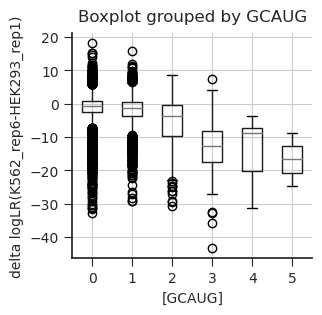

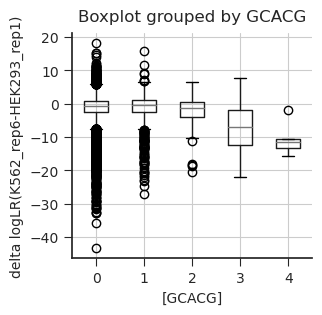

In [27]:
for m in ['GCAUG', 'GCACG']:
    mega_df.boxplot(by = [m], column = f'delta_logLR', figsize = (3,3))
    plt.ylabel(f'delta logLR({out_stem}-{out_stem2})')
    plt.title('')
    sns.despine()
    plt.show()

In [29]:
ccle_exon = pd.read_csv('/tscc/projects/ps-yeolab5/hsher/ccle_datasets/CCLE_RNAseq_ExonUsageRatio_20180929.gct.gz',
                   comment = '#', sep = '\t', skiprows = 2, na_values = '     NA')[['exon', 'gene_id','K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE','HEKTE_KIDNEY']].dropna()

In [30]:
ccle_exon = ccle_exon.loc[~ccle_exon.eq('     NA').any(axis = 1)]
ccle_exon['K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE'] = ccle_exon['K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE'].astype(float)
ccle_exon['HEKTE_KIDNEY'] = ccle_exon['HEKTE_KIDNEY'].astype(float)

In [31]:
ccle_exon.dtypes

exon                                        object
gene_id                                     object
K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    float64
HEKTE_KIDNEY                               float64
dtype: object

In [32]:
ccle_exon[['chrom_hg19', 'start_hg19', 'end_hg19', 'gene', 'strand'
         ]]=ccle_exon['exon'].str.split('_', expand = True)[[0,1,2,3,4]]
ccle_exon['start_hg19'] = ccle_exon['start_hg19'].astype(int)
ccle_exon['end_hg19'] = ccle_exon['end_hg19'].astype(int)

In [33]:
minus = ccle_exon.loc[ccle_exon['start_hg19']>ccle_exon['end_hg19']]
plus = ccle_exon.loc[ccle_exon['start_hg19']<ccle_exon['end_hg19']]
minus=minus.rename({'start_hg19':'end_hg19',
              'end_hg19':'start_hg19'
             }, axis = 1)

In [34]:
ccle_exon = pd.concat([minus, plus], axis = 0)

In [35]:
ccle_exon.loc[ccle_exon['start_hg19']>ccle_exon['end_hg19']]

,exon,gene_id,K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HEKTE_KIDNEY,chrom_hg19,end_hg19,start_hg19,gene,strand


In [36]:
ccle_exon[['chrom_hg19', 'start_hg19', 'end_hg19', 'exon']].to_csv('/home/hsher/scratch/ccle_exon.bed',
                                                                   sep = '\t',
                                                                   index = False,
                                                                   header = False)
#liftOver /home/hsher/scratch/ccle_exon.bed ~/liftover_chain/hg19ToHg38.over.chain /home/hsher/scratch/ccle_exon_hg38.bed /home/hsher/scratch/ccle_exon_hg38.nomap

OSError: Cannot save file into a non-existent directory: '/home/hsher/scratch'

In [ ]:
hg38 = pd.read_csv('/tscc/nfs/home/hsher/scratch/ccle_exon_hg38.bed', sep = '\t',
            names = ['chrom', 'start', 'end', 'exon']
           )

In [ ]:
ccle_exon = ccle_exon.merge(hg38, left_on = 'exon', right_on = 'exon')

In [ ]:
print(
    ccle_exon.loc[(ccle_exon['HEKTE_KIDNEY']-ccle_exon['K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE'])>0.2].shape,
    ccle_exon.loc[(ccle_exon['HEKTE_KIDNEY']-ccle_exon['K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE'])<-0.2].shape
)

In [ ]:
ccle_exon = ccle_exon.loc[~ccle_exon['chrom'].str.contains('_')]

In [ ]:

gencode_coords = BedTool('/tscc/nfs/home/hsher/gencode_coords/gencode.v38.primary_assembly.annotation.gff3')
gene2strand = {}
for g in gencode_coords:
    if g[2]=='gene':
        gene2strand[g.attrs['gene_name']]=g.strand

In [ ]:
ccle_exon['strand']=ccle_exon['gene'].map(gene2strand)

In [ ]:
ccle_exon=ccle_exon[~ccle_exon['strand'].isnull()]

In [ ]:

GENOMEFA='/tscc/nfs/home/hsher/gencode_coords/GRCh38.primary_assembly.genome.fa.txt'
change = 0.3
windows_bed = BedTool.from_dataframe(mega_df[['chrom', 'start', 'end', 'name', 'feature_type_top', 'strand']])
exon_up = BedTool.from_dataframe(ccle_exon.loc[(ccle_exon['HEKTE_KIDNEY']-ccle_exon['K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE'])>change,
             ['chrom', 'start', 'end', 'gene', 'exon', 'strand']
             ]
            )
intron5_up=exon_up.flank(l=250, r=0, s = True, g = GENOMEFA)
intron3_up=exon_up.flank(r=250, l=0, s = True, g = GENOMEFA)


exon_down = BedTool.from_dataframe(ccle_exon.loc[(ccle_exon['HEKTE_KIDNEY']-ccle_exon['K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE'])<-change,
             ['chrom', 'start', 'end', 'gene', 'exon', 'strand']
             ]
            )

intron5_down=exon_down.flank(l=250, r=0,s = True, g = GENOMEFA)
intron3_down=exon_down.flank(r=250, l=0, s = True, g = GENOMEFA)

In [ ]:
len(intron3_down), len(exon_down)

In [ ]:
rbp = 'RBFOX2'
f, axes = plt.subplots(2,3, figsize = (9,6))
axes = axes.flatten()

for region, color, ax in zip([intron5_up, exon_up, intron3_up,
               intron5_down, exon_down, intron3_down],
                         ['orchid', 'tomato', 'orange',
               'seagreen', 'royalblue', 'skyblue'],
                             axes
                        ):
    mega_df.plot.scatter(x = f'logLR:{out_stem}.{rbp}', y=f'logLR:{out_stem2}.{rbp}'
                    , color = 'lightgrey', alpha = 0.3, marker = '+', ax = ax)
    
    names = windows_bed.intersect(region).to_dataframe()['name']

    mega_df.loc[mega_df['name'].isin(names)].plot.scatter(x = f'logLR:{out_stem}.{rbp}', y=f'logLR:{out_stem2}.{rbp}'
                        , color = color,  marker = '.', ax = ax)
    # sns.kdeplot(mega_df.loc[mega_df['name'].isin(names)], x = f'logLR:{out_stem}.{rbp}', y=f'logLR:{out_stem2}.{rbp}',
    #             color = color,  ax = ax)
    
    #sns.kdeplot(mega_df.sample(1000),x = f'logLR:{out_stem}.{rbp}', y=f'logLR:{out_stem2}.{rbp}')
    ax.plot([-10,50], [-10,50], '--', color = 'black')
    # ax.set_xlim(0,50)
    # ax.set_ylim(0,50)
sns.despine()

In [ ]:
rbps = list(set([i.split('.')[-1] for i in mega_df.columns[mega_df.columns.str.startswith('logLR:')]]))

In [ ]:
from scipy.stats import pearsonr
f, axes = plt.subplots(2,5,figsize = (10,4))

for rbp, ax in zip(rbps, axes.flatten()):
    mega_df.sample(5000).plot.scatter(x = f'logLR:{out_stem}.{rbp}', y=f'logLR:{out_stem2}.{rbp}',
                        ax = ax, marker = '+', color = 'grey', alpha = 0.3)
    max_value = max(mega_df[f'logLR:{out_stem}.{rbp}'].max(),
                    mega_df[f'logLR:{out_stem2}.{rbp}'].max()
                   )
    min_value = min(mega_df[f'logLR:{out_stem}.{rbp}'].min(),
                    mega_df[f'logLR:{out_stem2}.{rbp}'].min()
                   )
    r,p=pearsonr(mega_df[f'logLR:{out_stem}.{rbp}'],mega_df[f'logLR:{out_stem2}.{rbp}'])
    ax.plot([min_value,max_value], [min_value,max_value], '--', color = 'black')
    ax.set_ylabel(out_stem2)
    ax.set_xlabel(out_stem)
    ax.set_title(f'{rbp}\npearson={r:.2f}')
plt.tight_layout()
sns.despine()
plt.savefig(figdir / 'repro_k562vshek.pdf')

In [ ]:
f, axes = plt.subplots(2,5,figsize = (10,4))

for rbp, ax in zip(rbps, axes.flatten()):
    mega_df.sample(5000).plot.scatter(x = f'logLR:{out_stem}.{rbp}', y=f'logLR:{out_stem1}.{rbp}',
                        ax = ax, marker = '+', color = 'grey', alpha = 0.3)
    max_value = max(mega_df[f'logLR:{out_stem}.{rbp}'].max(),
                    mega_df[f'logLR:{out_stem1}.{rbp}'].max()
                   )
    min_value = min(mega_df[f'logLR:{out_stem}.{rbp}'].min(),
                    mega_df[f'logLR:{out_stem1}.{rbp}'].min()
                   )
    r,p=pearsonr(mega_df[f'logLR:{out_stem}.{rbp}'],mega_df[f'logLR:{out_stem1}.{rbp}'])
    ax.plot([min_value,max_value], [min_value,max_value], '--', color = 'black')
    ax.set_ylabel(out_stem1)
    ax.set_xlabel(out_stem)
    ax.set_title(f'{rbp}\npearson={r:.2f}\n pval={p:.2e}')
plt.tight_layout()
sns.despine()
plt.savefig(figdir / 'repro_k562.pdf')

In [ ]:
f, axes = plt.subplots(2,5,figsize = (10,4))

for rbp, ax in zip(rbps, axes.flatten()):
    mega_df.sample(5000).plot.scatter(x = f'logLR:{out_stem2}.{rbp}', y=f'logLR:{out_stem3}.{rbp}',
                        ax = ax, marker = '+', color = 'grey', alpha = 0.3)
    max_value = max(mega_df[f'logLR:{out_stem2}.{rbp}'].max(),
                    mega_df[f'logLR:{out_stem3}.{rbp}'].max()
                   )
    min_value = min(mega_df[f'logLR:{out_stem2}.{rbp}'].min(),
                    mega_df[f'logLR:{out_stem3}.{rbp}'].min()
                   )
    r,p=pearsonr(mega_df[f'logLR:{out_stem2}.{rbp}'],mega_df[f'logLR:{out_stem3}.{rbp}'])
    ax.plot([min_value,max_value], [min_value,max_value], '--', color = 'black')
    ax.set_ylabel(out_stem2)
    ax.set_xlabel(out_stem3)
    ax.set_title(f'{rbp}\npearson={r:.2f}\n pval={p:.2e}')
plt.tight_layout()
sns.despine()
plt.savefig(figdir / 'repro_hek.pdf')

In [ ]:
gc_df = pd.read_csv('/tscc/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.nuc.gz', sep = '\t')
mega_df['gc']=gc_df.set_index('4_usercol')['8_pct_gc']
mega_df['gc_bin'] = pd.qcut(mega_df['gc'], q = 10)
f, ax = plt.subplots(2, len(rbps), figsize = (len(rbp)*3, 6), sharex = True)

for j, rbp in enumerate(rbps):
    mega_df['delta_logLR_between_K562']=mega_df[f'logLR:{out_stem}.{rbp}']-mega_df[f'logLR:{out_stem1}.{rbp}']
    mega_df['delta_logLR_between_HEK']=mega_df[f'logLR:{out_stem2}.{rbp}']-mega_df[f'logLR:{out_stem3}.{rbp}']

    mega_df.boxplot(by = 'gc_bin', column=f'delta_logLR_between_K562', rot = 90, ax = ax[0,j],showfliers=False)
    mega_df.boxplot(by = 'gc_bin', column=f'delta_logLR_between_HEK', rot = 90,  ax = ax[1,j],showfliers=False)
    
    ax[0,j].set_title(rbp)
    ax[0,j].set_ylabel('delta logLR(K562)')
    ax[1,j].set_ylabel('delta logLR(HEK)')

sns.despine()

# Functional Relevance: Magnitude of binding vs Magnitude of AS change upon KD

## RBFOX2 v.s. Skipped Exon

In [39]:
import pybedtools
pybedtools.set_bedtools_path('/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/bin/')
from pybedtools import BedTool
import pandas as pd
import numpy as np
from scipy.stats import chisquare

import os
from pathlib import Path
import sys
data_dir = Path('/tscc/nfs/home/hsher/projects/oligo_results/Final_published_figures')
sys.path.append(str(data_dir))

from plot_params import *


# load all splicing data for HEK293 RBFOX2 KD
regions_dict = {}
for group in ['in', 'ex', 'ctrl']:
    regions = []
    # (ce, ue, de, fiu, fid)
    for region in ['casette', 'exon5', 'exon3', 'intron5_to_casette', 'intron3_to_casette']:
    
        bedfile = BedTool(data_dir/f'data/rbfox2_splicing_data/HEK293T.{group}.{region}.bed')
        
        regions_dict[group, region] = bedfile

In [54]:
from scipy.stats import pearsonr
def binding_to_splicing(event, region, regions_dict = regions_dict, binding_df = df2, logLR_col = f'logLR:{out_stem2}.RBFOX2'
                       ):
    splice_and_bind = regions_dict[event, region].intersect(BedTool.from_dataframe(
    binding_df[['chrom', 'start', 'end', 'name', logLR_col, 'strand']]),
                                        wa = True, wb = True, s = True).to_dataframe()
    
    
    grouped = splice_and_bind.groupby(by = ['chrom', 'start', 'end', 'name', 'score', 'strand'])['blockSizes'].max().reset_index()
    # f, ax = plt.subplots(1,1, figsize = (3,3), sharex = True)
    sns.lmplot(data = grouped, x = 'blockSizes', y = 'score', height = 3, markers = '.')
    print(pearsonr(grouped['blockSizes'], grouped['score']))
    
    plt.xlabel(f'binding strength in {region}\n{logLR_col}')
    plt.ylabel('\delta SepScore')
    sns.despine()
    
    return grouped

PearsonRResult(statistic=-0.5184168345796419, pvalue=0.00199720376270778)


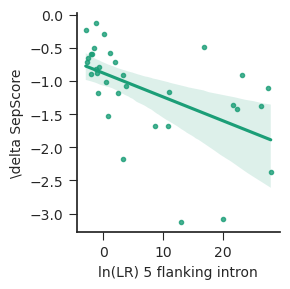

In [55]:
#_=binding_to_splicing('in', 'intron5_to_casette')
_=binding_to_splicing('in', 'intron5_to_casette', binding_df = df3, logLR_col=f'logLR:{out_stem3}.RBFOX2')
plt.xlabel('ln(LR) 5 flanking intron')
plt.savefig(figdir/'logLR_rbfox2_SE_incl.pdf')

PearsonRResult(statistic=0.46989917760152305, pvalue=0.0005032173528150132)


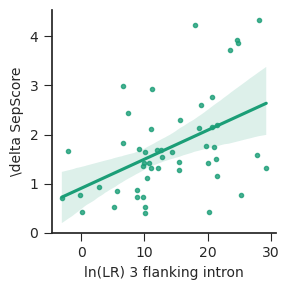

In [56]:
#_=binding_to_splicing('ex', 'intron3_to_casette')
_=binding_to_splicing('ex', 'intron3_to_casette', binding_df = df3, logLR_col=f'logLR:{out_stem3}.RBFOX2')
plt.xlabel('ln(LR) 3 flanking intron')
plt.savefig(figdir/'logLR_rbfox2_SE_excl.pdf')